In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Parameters
TRAIN_BATCH_SIZE = 50
TEST_BATCH_SIZE = 50
VALIDATION_SIZE = 5000

# Convert class labels from scalars to one-hot vectors 
# 2 => [0 0 1 0 0 0 0 0 0 0]
# 5 => [0 0 0 0 0 1 0 0 0 0]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


# Serve data by batches
def next_batch(batch_size):    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [2]:
# read input train data from csv file
train_data = pd.read_csv('./input/train.csv')

images = train_data.iloc[:,1:].values
images = images.astype(np.float)

# Normalize from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)
image_size = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

# For labels
labels_flat = train_data[[0]].values.ravel()
labels_count = np.unique(labels_flat).shape[0]
labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

# read test data from CSV file 
test_images = pd.read_csv('./input/test.csv').values

test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


train_images(27000,784)
validation_images(5000,784)
test_images(10000,784)


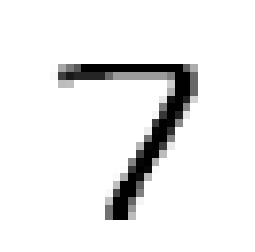

In [3]:
# display image
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

# output image     
display(images[1234])

In [4]:
sess = tf.InteractiveSession()



x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


In [5]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)


In [ ]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())


epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

In [ ]:
train_accuracies = []
validation_accuracies = []
x_range = []

for i in range(2000):
  batch_images,batch_labels = next_batch(TRAIN_BATCH_SIZE)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch_images, y_: batch_labels, keep_prob: 1.0})
    if(VALIDATION_SIZE):
        validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:TEST_BATCH_SIZE], 
                                                            y_: validation_labels[0:TEST_BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
        print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
        validation_accuracies.append(validation_accuracy)
    else: 
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_accuracies.append(train_accuracy)
    x_range.append(i)
  train_step.run(feed_dict={x: batch_images, y_: batch_labels, keep_prob: 0.5})

training_accuracy / validation_accuracy => 0.12 / 0.16 for step 0
training_accuracy / validation_accuracy => 0.84 / 0.84 for step 100


In [ ]:
# check final accuracy on validation set separated from input train data set
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

if(VALIDATION_SIZE > 0):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels,
                                                   keep_prob: 1.0})

    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()
    
    print('validation_accuracy => %.4f'%validation_accuracy)

The above graph shows change in training and validation accuracies as the training steps progresses. Here for generating the graph only 2000 iterations are run where as to generate csv output file 20000 iteration are run in GPU.

In [ ]:
predict = tf.argmax(y_conv, 1)
EVAL_BATCH_SIZE = 50
# generating predicted labels using batches
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//EVAL_BATCH_SIZE):
    predicted_lables[i*EVAL_BATCH_SIZE : (i+1)*EVAL_BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*EVAL_BATCH_SIZE : (i+1)*EVAL_BATCH_SIZE], keep_prob: 1.0})


In [ ]:
# write output - save results to csv file
np.savetxt('ChaitanyaSubmissionFinal.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')